In [31]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import np_utils
from keras import backend as K
import sys, os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import cv2
import pickle
from keras.utils.data_utils import get_file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import cv2

%matplotlib inline

In [2]:
def get_accidents_dataset(PATH,categories):
    
    train = dict()
    test  = dict()
    validate = dict()
    
    for i in categories:        
        train[i]  = os.listdir(f'{PATH}/{i}/')

    for i in train:
        print(f"train: {len(train[i])}")
        
    return train

In [3]:
def show_sample_images(categories):
    for categorie in categories:
        sample_normal = random.sample(train[categorie],6)
        print(sample_normal)
        f,ax = plt.subplots(2,3,figsize=(15,9))

        for i in range(0,6):
            im = cv2.imread(f'{PATH}/{categorie}/{sample_normal[i]}')
            ax[i//3,i%3].imshow(im)
            ax[i//3,i%3].axis('off')
        f.suptitle(f'{categorie.upper()}')
        plt.show()

In [4]:
PATH=r'./resized_images/portugal/MODEL1'
categories =  ['ACCIDENTS','SAFE']
print(categories)
train = get_accidents_dataset(PATH,categories)

['ACCIDENTS', 'SAFE']
train: 37919
train: 45502


['-8.36772344522112_-8.365482133406834_39.472368157642606_39.474169562097075.jpg', '-8.585130691206873_-8.582889379392586_40.42523279868948_40.42703390621189.jpg', '-8.006872243121057_-8.004630931306771_38.64726620245071_38.64906786249465.jpg', '-7.713260395449578_-7.711019083635291_41.817320582430355_41.81912125340314.jpg', '-8.677024475592603_-8.674783163778317_39.61467738471712_39.61647874493831.jpg', '-8.405825746063984_-8.403584434249696_41.23927594901691_41.241076801603754.jpg']


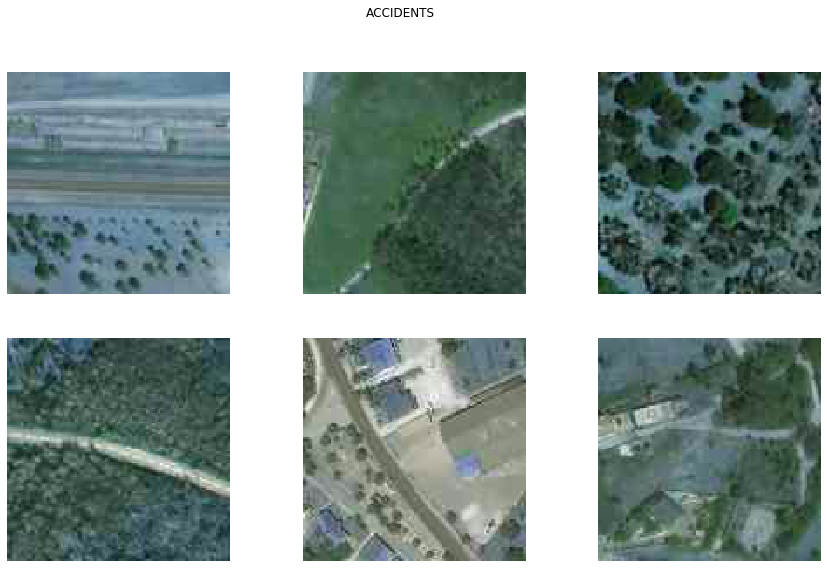

['-7.735673513592437_-7.733432201778152_41.403151219793465_41.404952020938104.jpg', '-9.264248170935565_-9.262006859121275_39.171525768186825_39.17332726600925.jpg', '-7.4353377304781_-7.433096418663814_41.086201414165075_41.088002314769064.jpg', '-7.623607922878133_-7.621366611063848_38.885080514923025_38.886882101459044.jpg', '-8.439445423278277_-8.43720411146399_38.57339766169835_38.57519934454736.jpg', '-8.746505141835472_-8.744263830021188_41.92896111151169_41.930761747359746.jpg']


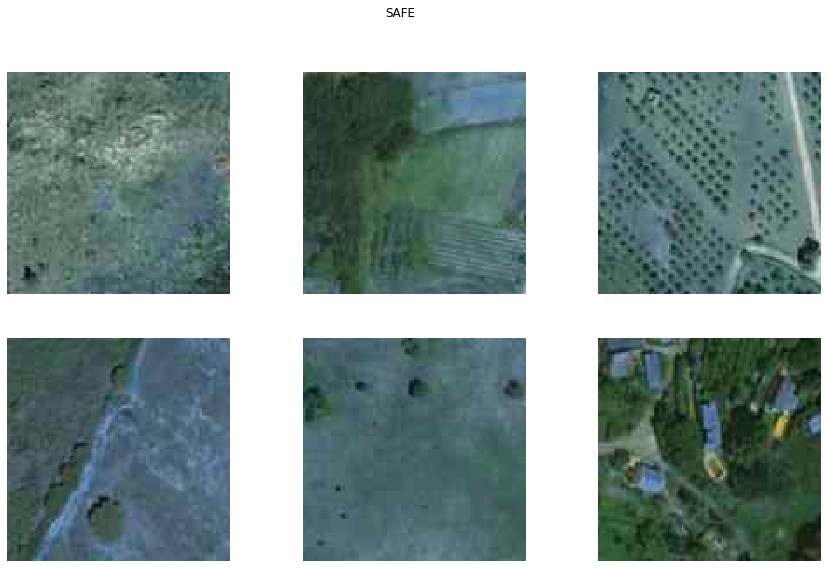

In [5]:
show_sample_images(categories)

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [7]:
image_height = 64 #150
image_width = 64#150
batch_size_train = int(66738*0.2) #10
batch_size_validation = int(16683*0.2)
no_of_epochs  = 20 #10


train_generator = train_datagen.flow_from_directory(
        PATH,
        target_size=(image_width,image_height),
        batch_size=batch_size_train,
        subset='training',
        class_mode="categorical")

validation_generator = train_datagen.flow_from_directory(
        PATH, 
        target_size=(image_width,image_height),
        batch_size=batch_size_validation,
        subset='validation',
        class_mode="categorical")

X_train, y_train = train_generator.next()
X_test, y_test = validation_generator.next()

Found 66738 images belonging to 2 classes.
Found 16683 images belonging to 2 classes.


In [8]:
def create_Autoencoder():
    input_image= Input(shape=(64,64,3))
    encoded1 = Dense(units=128, activation='relu')(input_image)
    encoded2 = Dense(units=64, activation='relu')(encoded1)
    encoded_final = Dense(units=32, activation='relu')(encoded2)
    decoded1 = Dense(units=64, activation='relu')(encoded_final)
    decoded2 = Dense(units=128, activation='relu')(decoded1)
    decoded_final = Dense(units=3, activation='sigmoid')(decoded2)
     
    encoder = Model(inputs=input_image, outputs=encoded_final) #só até gargalo (latent space) na rede entre antes de entrar do decoder
    autoencoder = Model(inputs=input_image, outputs=decoded_final)
    return autoencoder, encoder

(autoencoder, encoder) = create_Autoencoder()
print("\n############### ENCODER #################")
encoder.summary()
print("\n############### ENCODER + DECODER #################")
autoencoder.summary()


############### ENCODER #################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 64, 64, 128)       512       
_________________________________________________________________
dense_2 (Dense)              (None, 64, 64, 64)        8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64, 64, 32)        2080      
Total params: 10,848
Trainable params: 10,848
Non-trainable params: 0
_________________________________________________________________

############### ENCODER + DECODER #################
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 

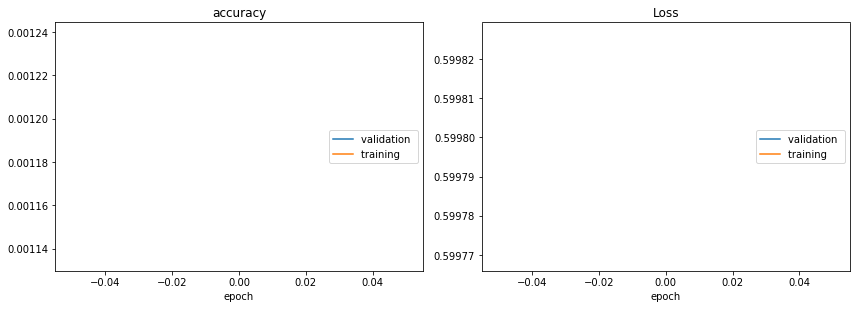

accuracy
	validation       	 (min:    0.001, max:    0.001, cur:    0.001)
	training         	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	validation       	 (min:    0.600, max:    0.600, cur:    0.600)
	training         	 (min:    0.600, max:    0.600, cur:    0.600)
Scores:  [0.5998264431095809, 0.0012392671778798103]
Erro autoencoder: 99.88%


In [9]:
def compiletrain(autoencoder, X_train, X_test):
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = autoencoder.fit(X_train, X_train, 
                              epochs=1, 
                              batch_size=32, 
                              shuffle=True, 
                              validation_data=(X_test, X_test),
                              verbose=2,
                              callbacks=[PlotLossesKeras()])
    # Avaliação final com os casos de teste
    scores = autoencoder.evaluate(X_test, X_test, verbose=0)
    print('Scores: ', scores)
    print("Erro autoencoder: %.2f%%" % (100-scores[1]*100))                                                                                                                                
    return autoencoder,history

(autoencoder,history)=compiletrain(autoencoder, X_train, X_test)

first 10 images of X_test
Distancia: 56.80716925067827
Distancia: 91.77522672526538
Distancia: 92.48739416094031
Distancia: 65.39814356993884
Distancia: 51.60482159256935
Distancia: 67.67778059944976
Distancia: 64.01845896826126
Distancia: 54.39763373811729
Distancia: 87.96299024566542
Distancia: 44.99641418654937


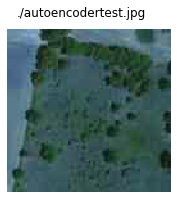

Distancia 232.76813


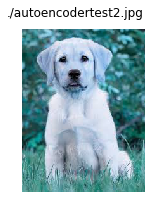

Distancia 177.65979


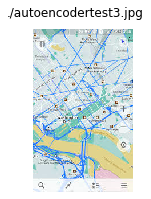

Distancia 343.37442


In [37]:
def visualize_distancia_previsoes(encoder,autoencoder,X_test):
    encoded_images = encoder.predict(X_test)
    predicted_images = autoencoder.predict(X_test)  
    # Original Images
    print("first 10 images of X_test")
    for i in range(10):
        
        dist = sum(np.linalg.norm(X_test[i].reshape(64*64,3) - 
                              predicted_images[i].reshape(64*64,3), axis=-1))
        print("Distancia:",dist)
    
visualize_distancia_previsoes(encoder,autoencoder,X_test[:10])


from keras.preprocessing import image
# se a imagem imagem_nao_digito.png não for um digito do genero em que foi treinado então a distancia entre os dois vetores será muito grande.

def show_image(path,title):
  f,ax = plt.subplots(1,1,figsize=(8,3))
  im = cv2.imread(path)
  ax.imshow(im)
  ax.axis('off')
  f.suptitle(title)
  plt.show()

def calculate_distance(picture):
    show_image(picture,picture)
    img = image.load_img(picture, target_size=(64,64,3))
    input_img = image.img_to_array(img)
    inputs = input_img.reshape(1,64,64,3)
    target_data = autoencoder.predict(inputs)
    dist = sum(np.linalg.norm(inputs.reshape(1,64*64,3) - target_data.reshape(1,64*64,3), axis=-1))
    print("Distancia",dist[0])

calculate_distance("./autoencodertest.jpg")
calculate_distance("./autoencodertest2.jpg")
calculate_distance("./autoencodertest3.jpg")